In [1]:
import torch
import pickle
import numpy as np
from torch import nn
from tqdm.contrib import tzip
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

In [2]:
def embedding_index(sentence, word):
    index = sentence.split(" ").index(word)
    return index

# Measures

In [3]:
from scipy.spatial.distance import cosine
def measure_similarity(a, b):
    cosine_value = 1 - cosine(a, b)
    euclid_value = np.linalg.norm(a-b)
    return cosine_value, euclid_value

# Bert

In [4]:
class BertBatchEmbedding:
    def __init__(self):
        self.model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True).eval().cuda()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    def transform(self, sentences):
        padded_sequence = self.tokenizer.batch_encode_plus(sentences, return_tensors="pt", pad_to_max_length=True)
        out = self.model(padded_sequence['input_ids'].cuda(), padded_sequence["attention_mask"].cuda())
        hidden_states = out[2]
        token_embeddings = torch.stack(hidden_states, dim=0)
        token_embeddings = torch.flatten(token_embeddings.permute(1, 2, 0,3), start_dim=2)[:,1:-1,:]
        return token_embeddings.cpu().detach().numpy()
    
    def parameters(self):
        return self.model.parameters()
    
bert = BertBatchEmbedding()

# Custom Bert

In [5]:
class CustomTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
    def tokenize(self, sentences : list):
        encoded = []
        for sentence in sentences:
            tokens = self.tokenizer.tokenize(sentence)
            encoded_sentence = []
            for token in tokens:
                if token in self.vocabulary:
                    encoded_sentence.append(self.vocabulary[token])
                else:
                    encoded_sentence.append(self.vocabulary["<UNK>"])
            encoded.append(encoded_sentence)
        return torch.tensor(encoded)

In [6]:
class CustomBertEmbedding:
    def __init__(self):
        with open('datasets/weights.pickle', 'rb') as handle:
            weights = torch.tensor(pickle.load(handle))
            
        with open('datasets/vocab.pickle', 'rb') as handle:
            vocabulary = pickle.load(handle)
            
        self.model = nn.Embedding.from_pretrained(weights, padding_idx = 0, freeze = True)
        self.tokenizer = CustomTokenizer(vocabulary)
        
    def transform(self, text):
        tokenized_text = self.tokenizer.tokenize(text).long()
        embedded_text = self.model(tokenized_text)
        return embedded_text
    
    
    def parameters(self):
        return self.model.parameters()
    
custom = CustomBertEmbedding()

# Context hypotehesis testing
- BERT encodes words based on context meaning that the model looks at the whole sentence and encodes the word based on the meaining it has in the sentence. Words that are in a more similar context are more similar.
- We also need to define what the core meaining of the word is. The core meaning of the word is the meaining that the word has regardless of the context. The only thing the word knows is its true meaning regarding to polysemi.

In [7]:
max_sentence = "He brutally killed someone"
embedding = bert.transform([max_sentence])[0]
max_embedding = embedding[embedding_index(max_sentence,"killed")]

In [8]:
min_sentence = "He accidentally killed someone"
embedding = bert.transform([min_sentence])[0]
min_embedding = embedding[embedding_index(min_sentence,"killed")]

In [9]:
indif_sentence = "He killed someone"
embedding = bert.transform([indif_sentence])[0]
indif_embedding = embedding[embedding_index(indif_sentence,"killed")]

In [10]:
huge_sentence = "Someone was killed in a horrifying manner"
embedding = bert.transform([huge_sentence])[0]
huge_embedding = embedding[embedding_index(huge_sentence, "killed")]

In [11]:
print(measure_similarity(max_embedding, huge_embedding))
print(measure_similarity(min_embedding, huge_embedding))
print(measure_similarity(indif_embedding, huge_embedding))

(0.7988684177398682, 43.771984)
(0.7915605306625366, 44.648533)
(0.7995526790618896, 43.83039)


In [41]:
core_sentence = "killed"
embedding = custom.transform([core_sentence])[0]
core_embedding = embedding[0]

In [42]:
print(measure_similarity(max_embedding, core_embedding))
print(measure_similarity(min_embedding, core_embedding))
print(measure_similarity(indif_embedding, core_embedding))

TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, Number alpha)
 * (Tensor input, Number other, Number alpha)


> <font size="3"> What would be the best way to represent the core meaning of a word so that we can capture the differences between the core meaning and the meaning inside the context?</font>
> - <font size="3"> We can use an embedding which we create from averaging multiple vector embbedings from the same word inside multiple contexts</font>
> - <font size="3"> We can use the basic embbeding of the word without any context at all. This would be the most robust solution since bert probably outputs the most generic embeddings.</font>

# Bert batch embedding
Since we will feed mutliple sentences in batches we need a way to preprocess the sentences in batches instead of sentence by sentence.

In [14]:
text = ["After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."]
embeddings = bert.transform(text)[0]
diff_bank = 1 - cosine(embeddings[9], embeddings[18])
same_bank = 1 - cosine(embeddings[9], embeddings[5])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.92
Vector similarity for *different* meanings:  0.71


There are multiple ways to create vector embeddings from bert. You can avarage all the hidden layers. You can also avarage the last 4 layers. You can concat the last 4 layers instead of averaging. So this is also a part of our work that will need a lot of testing. We should probably create a table that contains all the different vector embeddings and compare their preformance. 

# Dataset exploration

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 5000)

/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
filename = "train"
data = open("datasets/Processed/"+filename+".txt", "r").read().split("\n")

In [17]:
X = []
Y = []
x = []
y = []
for i in data:
    if i=="":
        X.append(" ".join(x))
        Y.append(y)
        x = []
        y = []
    else:
        row = i.split(" ")
        x.append(row[0])
        y.append(int(row[1]))

In [18]:
import re
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
Y_new = []
X_new = []
locations = []
special = []
for x,y in zip(X,Y):
    tokenized = tokenizer.tokenize(x)
    X_new.append(tokenized)
    split_x = x.lower().split(" ")
    counter = 0
    new_y = []
    local = []
    local_special = []
    word = ""
    for i, token in enumerate(tokenized):
        word = word + token.replace("#","")
        if word == split_x[counter]:
            new_y.append(y[counter])
            counter+=1
            word = ""
            if "#" in token:
                local.append(i)
        else:
            new_y.append(y[counter])
            if "#" in token:
                local.append(i)
        if re.findall('[^A-Za-z0-9]',token) and not "#" in token:
            local_special.append(i)
    locations.append(local)
    special.append(local_special)
    assert len(new_y)!=tokenized
    for i,j in enumerate(tokenized):
        if not re.search('[a-zA-Z]', j):
            new_y[i] = 0
    Y_new.append(new_y)

In [19]:
def mean_std(df, lenght):
    cos_1 = df.loc[(df["label"]==1) & (df['token'].str.len()>lenght) & (df["is_word"]==1)]["cosine_value"].values
    cos_0 = df.loc[(df["label"]==0) & (df['token'].str.len()>lenght) & (df["is_word"]==1)]["cosine_value"].values
    euclid_1 = df.loc[(df["label"]==1) & (df['token'].str.len()>lenght) & (df["is_word"]==1)]["euclid_value"].values
    euclid_0 = df.loc[(df["label"]==0) & (df['token'].str.len()>lenght) & (df["is_word"]==1)]["euclid_value"].values
    sns.distplot(cos_1, hist=False, label="1")
    sns.distplot(cos_0, hist=False, label="0")
    plt.legend(loc="upper left")
    plt.show()
    print("1:",cos_1.mean(),cos_1.std(), euclid_1.mean(), euclid_1.std())
    sns.distplot(euclid_1, hist=False, label="1")
    sns.distplot(euclid_0, hist=False, label="0")
    plt.legend(loc="upper right")
    plt.show()
    print("0:",cos_0.mean(),cos_0.std(), euclid_0.mean(), euclid_0.std())


In [20]:
with open('datasets/vocab.pickle', 'rb') as handle:
    vocabulary = pickle.load(handle)
vocabulary

{'<PAD>': 0,
 '<UNK>': 1,
 'the': 2,
 ',': 3,
 '.': 4,
 'to': 5,
 'of': 6,
 'and': 7,
 'in': 8,
 'a': 9,
 'that': 10,
 '’': 11,
 's': 12,
 'is': 13,
 '“': 14,
 '”': 15,
 '-': 16,
 'for': 17,
 'it': 18,
 'on': 19,
 'was': 20,
 'he': 21,
 'with': 22,
 'as': 23,
 'this': 24,
 'be': 25,
 'by': 26,
 'not': 27,
 'his': 28,
 'have': 29,
 'are': 30,
 '##s': 31,
 ':': 32,
 'has': 33,
 'i': 34,
 'from': 35,
 'at': 36,
 'they': 37,
 'who': 38,
 "'": 39,
 'an': 40,
 'said': 41,
 '"': 42,
 'but': 43,
 'we': 44,
 'you': 45,
 '?': 46,
 't': 47,
 'will': 48,
 'trump': 49,
 'or': 50,
 'had': 51,
 ')': 52,
 '(': 53,
 'all': 54,
 'were': 55,
 'about': 56,
 'their': 57,
 'what': 58,
 'one': 59,
 'which': 60,
 'been': 61,
 'no': 62,
 'our': 63,
 'out': 64,
 'there': 65,
 'if': 66,
 '—': 67,
 'would': 68,
 'so': 69,
 'people': 70,
 'do': 71,
 'also': 72,
 'she': 73,
 'when': 74,
 'after': 75,
 'up': 76,
 'her': 77,
 'more': 78,
 'should': 79,
 'us': 80,
 'can': 81,
 'president': 82,
 'him': 83,
 'church': 8

In [43]:
token_df = []
for sentence, tokens, labels in tzip(X, X_new, Y_new):
    assert len(tokens)==len(labels)
    bembeddings = torch.tensor(bert.transform([sentence])[0])[:,768:][:,768*11:768*12]
    cembeddings = custom.transform([sentence])[0][:,768:][:,768*11:768*12]
    words = re.sub(r'[^A-Za-z0-9 ]+', '', sentence).split(" ")
    assert bembeddings.shape==cembeddings.shape
    for i,token in enumerate(tokens):
        cosine_value, euclid_value = measure_similarity(bembeddings[i,:], cembeddings[i,:])
        if token.isalpha():
            is_word = 1
        else:
            is_word = 0
        token_df.append([token, is_word, cosine_value, euclid_value, labels[i]])

In [45]:
df = df = pd.DataFrame.from_records(token_df)
df.columns = ["token", "is_word","cosine_value","euclid_value","label"]
df.head(1000)

,token,is_word,cosine_value,euclid_value,label
0,s,1,0.130456,17.505744,0
1,##nl,0,0.210791,19.037489,0
2,indian,1,0.768576,8.358497,0
3,comedian,1,0.727779,9.061160,0
4,silenced,1,0.605200,10.277896,0
5,for,1,0.647160,10.449612,0
6,"""",0,-0.049342,32.217613,0
7,offensive,1,0.751863,8.694816,0
8,jokes,1,0.846839,7.000805,0
9,"""",0,-0.046115,32.471105,0


In [46]:
df.shape

(342868, 5)

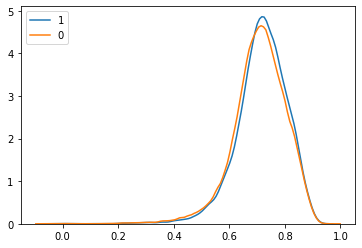

1: 0.7169309722895433 0.09150034761079172 9.842126400253925 1.7707319030456943


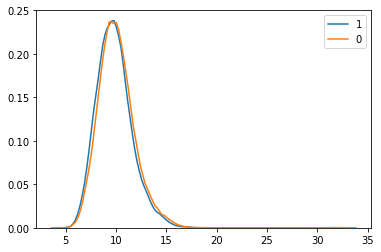

0: 0.70797820704331 0.09613736448511206 10.06943467088434 1.8231810624510374


In [47]:
mean_std(df, 2)

In [48]:
filtered = df.loc[df["token"].isin(list(vocabulary.keys())[100:])]
filtered.head(100)

,token,is_word,cosine_value,euclid_value,label
1,##nl,0,0.210791,19.037489,0
2,indian,1,0.768576,8.358497,0
3,comedian,1,0.727779,9.061160,0
4,silenced,1,0.605200,10.277896,0
7,offensive,1,0.751863,8.694816,0
8,jokes,1,0.846839,7.000805,0
11,columbia,1,0.514977,13.235706,0
12,andy,1,0.576118,13.033692,0
13,war,1,0.477813,15.341470,0
14,##hol,0,0.297487,18.340900,0


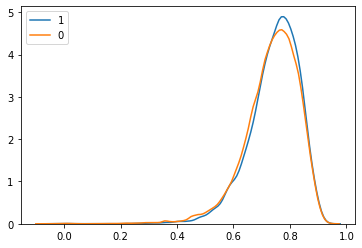

1: 0.7438794109100196 0.0901767819530444 9.271821579971212 1.739014868412315


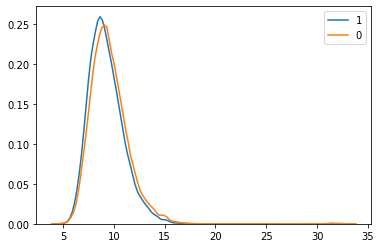

0: 0.7354389907676354 0.09677241381750988 9.570554829797079 1.8552948917254066


In [49]:
mean_std(filtered, 4)